#**Detección de anomalias en un conjunto patrones de acceso a la API en términos de métricas de comportamiento**





***CONTEXTO***

Normalmente se accede a las aplicaciones distribuidas basadas en microservicios a través de API. Estas API son utilizadas por las aplicaciones o se puede acceder a ellas directamente por medios programáticos. Muchas veces el acceso a las APIs es abusado por atacantes que intentan explotar la lógica de negocio expuesta por estas APIs. La forma en que los usuarios normales acceden a estas API es diferente de la forma en que los atacantes acceden a estas API. Muchas aplicaciones tienen cientos de APIs que son llamadas en un orden específico y dependiendo de varios factores como refrescos del navegador, refrescos de sesión, errores de red, o acceso programático estos comportamientos no son estáticos y pueden variar para el mismo usuario. Las llamadas a la API en sesiones de larga duración forman gráficos de acceso que deben analizarse para descubrir patrones de ataque y anomalías. Los gráficos no se prestan al cálculo numérico. Abordamos este problema y proporcionamos un conjunto de datos en el que el comportamiento de acceso de los usuarios se califica como características numéricas. Además, proporcionamos un conjunto de datos con gráficos de llamadas API sin procesar. Para facilitar el uso de estos conjuntos de datos, también se incluyen dos cuadernos sobre clasificación, incrustación de nodos y agrupación.

*Se cuenta con conjunto de datos en el que el comportamiento de acceso de los usuarios se califica como características numéricas. Además, proporcionamos un conjunto de datos con gráficos de llamadas API sin procesar. Para facilitar el uso de estos conjuntos de datos, también se incluyen dos cuadernos sobre clasificación, incrustación de nodos y agrupación.*


In [ ]:
!pip install pyspark
!pip install sktime
!pip install graphframes
!curl -L -o "/usr/local/lib/python3.6/dist-packages/pyspark/jars/graphframes-0.8.2-spark3.2-s_2.12.jar" http://dl.bintray.com/spark-packages/maven/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285388 sha256=332c7bee695f665336bbb66d1aa21e2d6388d877797eb9f1221a8c37afa2791c
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.7/118.7 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 4.8 MB/s eta 0:00:00
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   164  100   164    0     0    830      0 --:--:-- --:--:-- --:--:--   828
100   146  100   146    0     0    230      0 --:--:-- --:--:-- --:--:--   230
curl: (23) Failure writin

In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

In [ ]:
spark = SparkSession.builder.master("local[*]").config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.2-s_2.12").getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **CARGA DE DATOS**

In [ ]:
dataS = spark.read.csv("/content/drive/MyDrive/datasets/G8-GR-MICROSERVICIOS/supervised_dataset.csv",header=True)
dataS.show(5)
dataR = spark.read.csv("/content/drive/MyDrive/datasets/G8-GR-MICROSERVICIOS/remaining_behavior_ext.csv",header=True)
dataR.show(5)

+---+--------------------+------------------------------+---------------------+----------------------+----------------------+-------+------------+---------+---------------+------+--------------+
|_c0|                 _id|inter_api_access_duration(sec)|api_access_uniqueness|sequence_length(count)|vsession_duration(min)|ip_type|num_sessions|num_users|num_unique_apis|source|classification|
+---+--------------------+------------------------------+---------------------+----------------------+----------------------+-------+------------+---------+---------------+------+--------------+
|  0|1f2c32d8-2d6e-3b6...|          0.000812213726692...| 0.004066433440328921|     85.64324324324325|                  5405|default|      1460.0|   1295.0|          451.0|     E|        normal|
|  1|4c486414-d4f5-33f...|          6.324646128836197...| 0.002211465938298636|    16.166804782763112|                   519|default|      9299.0|   8447.0|          302.0|     E|        normal|
|  2|7e5838fc-bce1-371...

## **LIMPIEZA DE DATOS**

Este método se utiliza para eliminar filas que contienen valores faltantes (NaN) en un DataFrame. Los valores faltantes pueden ser problemáticos para muchos análisis y algoritmos, por lo que en ocasiones es necesario eliminar esas filas antes de realizar ciertas operaciones.

In [ ]:
dataS.drop_duplicates()
dataS.na.drop()

DataFrame[_c0: string, _id: string, inter_api_access_duration(sec): string, api_access_uniqueness: string, sequence_length(count): string, vsession_duration(min): string, ip_type: string, num_sessions: string, num_users: string, num_unique_apis: string, source: string, classification: string]

In [ ]:
dataR.drop_duplicates()
dataR.na.drop()

DataFrame[_c0: string, _id: string, inter_api_access_duration(sec): string, api_access_uniqueness: string, sequence_length(count): string, vsession_duration(min): string, ip_type: string, behavior: string, behavior_type: string, num_sessions: string, num_users: string, num_unique_apis: string, source: string]

In [ ]:
dataS.printSchema()
dataR.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _id: string (nullable = true)
 |-- inter_api_access_duration(sec): string (nullable = true)
 |-- api_access_uniqueness: string (nullable = true)
 |-- sequence_length(count): string (nullable = true)
 |-- vsession_duration(min): string (nullable = true)
 |-- ip_type: string (nullable = true)
 |-- num_sessions: string (nullable = true)
 |-- num_users: string (nullable = true)
 |-- num_unique_apis: string (nullable = true)
 |-- source: string (nullable = true)
 |-- classification: string (nullable = true)

root
 |-- _c0: string (nullable = true)
 |-- _id: string (nullable = true)
 |-- inter_api_access_duration(sec): string (nullable = true)
 |-- api_access_uniqueness: string (nullable = true)
 |-- sequence_length(count): string (nullable = true)
 |-- vsession_duration(min): string (nullable = true)
 |-- ip_type: string (nullable = true)
 |-- behavior: string (nullable = true)
 |-- behavior_type: string (nullable = true)
 |-- num_sessions: strin

## **Pre-procesamiento**

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType

dataS = dataS.withColumn("inter_api_access_duration(sec)", col("inter_api_access_duration(sec)").cast("float")) \
       .withColumn("api_access_uniqueness", col("api_access_uniqueness").cast("float")) \
       .withColumn("sequence_length(count)", col("sequence_length(count)").cast(IntegerType())) \
       .withColumn("vsession_duration(min)", col("vsession_duration(min)").cast(IntegerType())) \
       .withColumn("num_sessions", col("num_sessions").cast(IntegerType())) \
       .withColumn("num_users", col("num_users").cast(IntegerType())) \
       .withColumn("num_unique_apis", col("num_unique_apis").cast(IntegerType()))
dataS.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _id: string (nullable = true)
 |-- inter_api_access_duration(sec): float (nullable = true)
 |-- api_access_uniqueness: float (nullable = true)
 |-- sequence_length(count): integer (nullable = true)
 |-- vsession_duration(min): integer (nullable = true)
 |-- ip_type: string (nullable = true)
 |-- num_sessions: integer (nullable = true)
 |-- num_users: integer (nullable = true)
 |-- num_unique_apis: integer (nullable = true)
 |-- source: string (nullable = true)
 |-- classification: string (nullable = true)



In [ ]:
dataS.show(5)

+---+--------------------+------------------------------+---------------------+----------------------+----------------------+-------+------------+---------+---------------+------+--------------+
|_c0|                 _id|inter_api_access_duration(sec)|api_access_uniqueness|sequence_length(count)|vsession_duration(min)|ip_type|num_sessions|num_users|num_unique_apis|source|classification|
+---+--------------------+------------------------------+---------------------+----------------------+----------------------+-------+------------+---------+---------------+------+--------------+
|  0|1f2c32d8-2d6e-3b6...|                  8.1221375E-4|         0.0040664333|                    85|                  5405|default|        1460|     1295|            451|     E|        normal|
|  1|4c486414-d4f5-33f...|                   6.324646E-5|          0.002211466|                    16|                   519|default|        9299|     8447|            302|     E|        normal|
|  2|7e5838fc-bce1-371...

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType

dataR = dataR.withColumn("inter_api_access_duration(sec)", col("inter_api_access_duration(sec)").cast("float")) \
       .withColumn("api_access_uniqueness", col("api_access_uniqueness").cast("float")) \
       .withColumn("sequence_length(count)", col("sequence_length(count)").cast(IntegerType())) \
       .withColumn("vsession_duration(min)", col("vsession_duration(min)").cast(IntegerType())) \
       .withColumn("num_sessions", col("num_sessions").cast(IntegerType())) \
       .withColumn("num_users", col("num_users").cast(IntegerType())) \
       .withColumn("num_unique_apis", col("num_unique_apis").cast(IntegerType()))
dataR.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _id: string (nullable = true)
 |-- inter_api_access_duration(sec): float (nullable = true)
 |-- api_access_uniqueness: float (nullable = true)
 |-- sequence_length(count): integer (nullable = true)
 |-- vsession_duration(min): integer (nullable = true)
 |-- ip_type: string (nullable = true)
 |-- behavior: string (nullable = true)
 |-- behavior_type: string (nullable = true)
 |-- num_sessions: integer (nullable = true)
 |-- num_users: integer (nullable = true)
 |-- num_unique_apis: integer (nullable = true)
 |-- source: string (nullable = true)



In [ ]:
dataR.show(5)

+---+--------------------+------------------------------+---------------------+----------------------+----------------------+-------+--------+-------------+------------+---------+---------------+------+
|_c0|                 _id|inter_api_access_duration(sec)|api_access_uniqueness|sequence_length(count)|vsession_duration(min)|ip_type|behavior|behavior_type|num_sessions|num_users|num_unique_apis|source|
+---+--------------------+------------------------------+---------------------+----------------------+----------------------+-------+--------+-------------+------------+---------+---------------+------+
|  0|024aae60-1a81-3f3...|                      7.010387|           0.41935483|                    31|                 13040|default| outlier|      outlier|           1|        1|             13|     E|
|  1|028d67dd-c6d0-329...|                      51.41939|           0.25233644|                   107|                330113|default| outlier|      outlier|           1|        1|         

## **VISUALIZACIONES CON ANÁLISIS**

### ***ANÁLISIS EXPLORATORIO***

In [ ]:
import pyspark
import pandas as pd
import numpy as np
import seaborn as sns
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

In [ ]:
dfSupervisado = dataS.toPandas()

In [ ]:
dfRestante = dataR.toPandas()

Este histograma muestra la distribución de la duración de los accesos a una API específica dentro del sistema en segundos. Cada barra en el histograma representa un intervalo de tiempo y la altura de la barra muestra la cantidad de accesos que ocurrieron dentro de ese intervalo.

array([[<Axes: title={'center': 'inter_api_access_duration(sec)'}>,
        <Axes: title={'center': 'api_access_uniqueness'}>,
        <Axes: title={'center': 'sequence_length(count)'}>],
       [<Axes: title={'center': 'vsession_duration(min)'}>,
        <Axes: title={'center': 'num_sessions'}>,
        <Axes: title={'center': 'num_users'}>],
       [<Axes: title={'center': 'num_unique_apis'}>, <Axes: >, <Axes: >]],
      dtype=object)

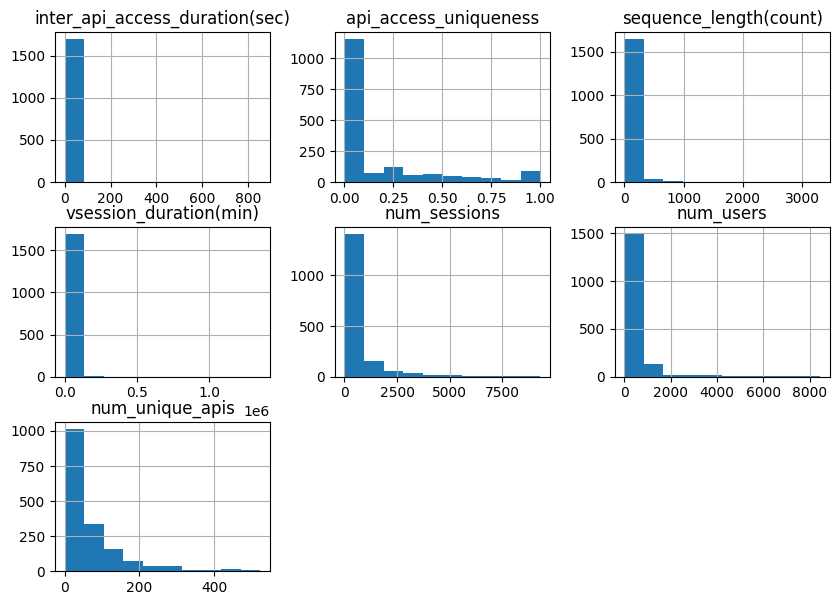

In [ ]:
dfSupervisado.hist(figsize=(10,7))

La caja (boxplot) representa la distribución del número de API únicas en el conjunto de datos, cuando se considera solo aquellos registros donde la longitud de la secuencia es menor a 50,000.

<ipython-input-17-1ec5b7fec253>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfSupervisado[dfRestante['sequence_length(count)']<50000]['num_unique_apis'].plot.box(color = color , vert=True)


<Axes: >

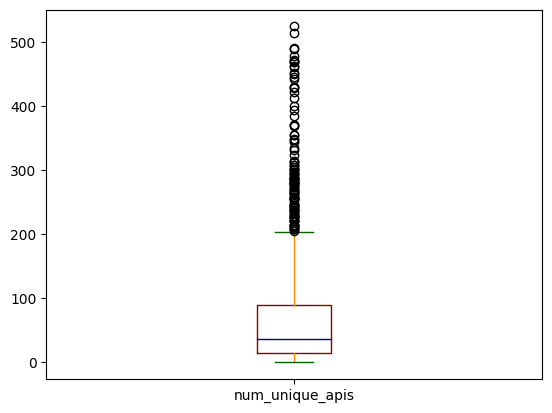

In [ ]:
color = {
    "boxes" : "DarkRed",
    "whiskers" : "DarkOrange",
    "medians" : "DarkBlue",
    "caps" : "DarkGreen"
}
dfSupervisado[dfRestante['sequence_length(count)']<50000]['num_unique_apis'].plot.box(color = color , vert=True)

En este gráfico:

El eje X (horizontal) representa la variable "num_sessions", que indica el número de sesiones realizadas por los usuarios. El eje Y (vertical) representa la variable "vsession_duration(min)", que indica la duración de la sesión virtual en minutos. Cada punto en el gráfico representa un registro en el conjunto de datos "dfSupervisado". La posición de cada punto se determina por los valores de "num_sessions" y "vsession_duration(min)" para ese registro específico.

La transparencia de los puntos está configurada mediante el parámetro "alpha=0.5", lo que significa que los puntos serán semi-transparentes. Esto puede ser útil cuando hay muchos puntos superpuestos y se desea visualizar mejor las densidades y patrones en los datos. La finalidad de este tipo de gráfico de dispersión es visualizar la relación o la distribución conjunta entre las dos variables.

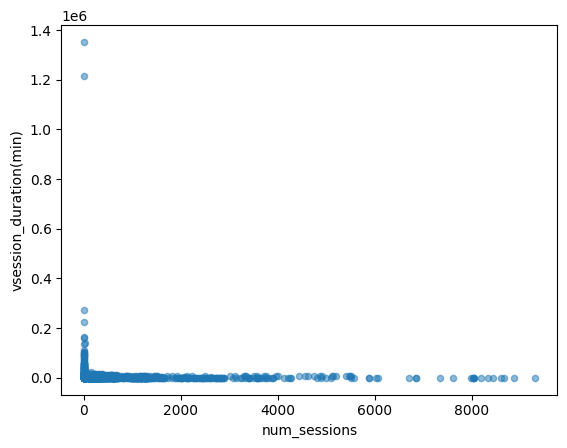

In [ ]:
var = 'num_sessions'
data = pd.concat([dfSupervisado['vsession_duration(min)'], dfSupervisado[var]], axis=1)
data.plot.scatter(x=var, y='vsession_duration(min)', alpha = 0.5);

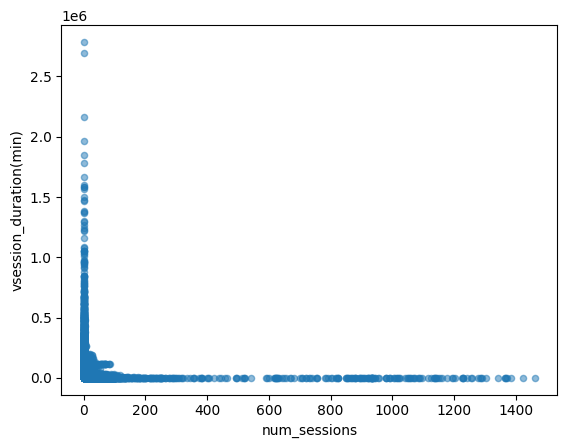

In [ ]:
# Diagrama de dispersión

var = 'num_sessions'
data = pd.concat([dfRestante['vsession_duration(min)'], dfRestante[var]], axis=1)
data.plot.scatter(x=var, y='vsession_duration(min)', alpha = 0.5);

Se realiza una visualización de datos en forma de un gráfico de caja para analizar cómo se distribuyen las longitudes de secuencia ('sequence_length(count)') en función de la variable 'classification'. Cada categoría dentro de 'classification' tendrá su propia caja en el gráfico, mostrando la distribución de las longitudes de secuencia asociadas con esa categoría.

Los límites del eje y están establecidos entre 0 y 300 para limitar el rango de valores mostrados en el gráfico.



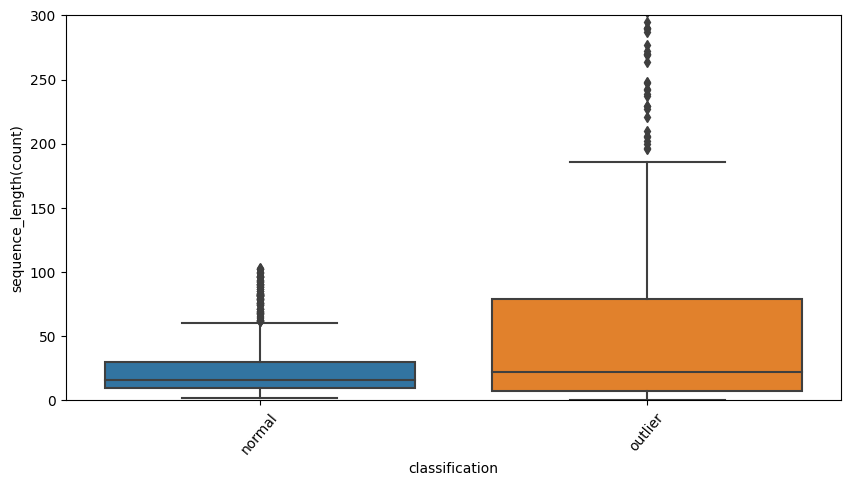

In [ ]:
var = 'classification'
data = pd.concat([dfSupervisado['sequence_length(count)'], dfSupervisado[var]], axis=1)
f, ax = plt.subplots(figsize=(10, 5))
fig = sns.boxplot(x=var, y="sequence_length(count)", data=data)
fig.axis(ymin=0, ymax=300);
plt.xticks(rotation=50);

El gráfico de dispersión muestra la relación entre dos variables numéricas y es útil para visualizar cómo se distribuyen los datos y si existe alguna relación entre las variables.

<Axes: >

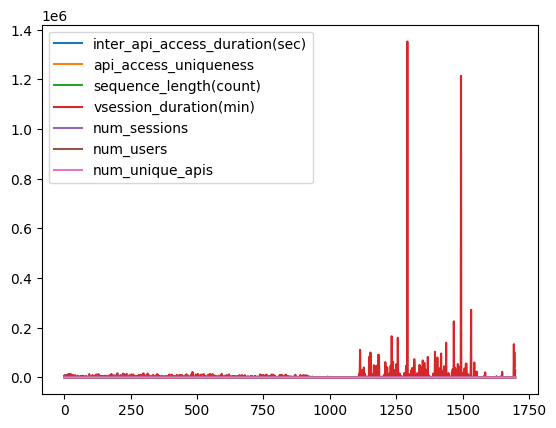

In [ ]:
dfSupervisado.plot()

El gráfico generado mostrará cómo las columnas "vsession_duration(min)", "por encima" y "por abajo" cambian a lo largo del índice del DataFrame. Esto puede ser útil para visualizar cómo los límites se ajustan a los datos y detectar posibles valores atípicos o tendencias en la columna "vsession_duration(min)".

<Axes: >

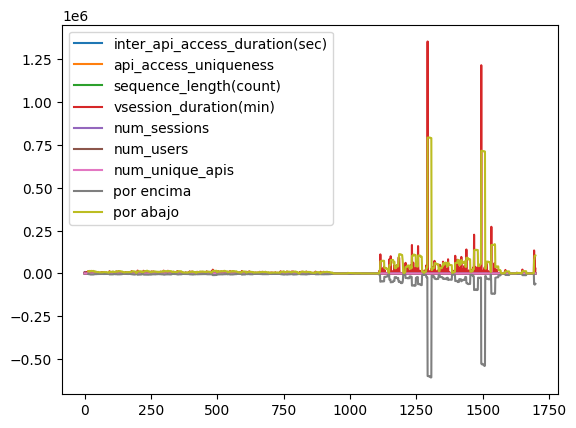

In [ ]:
wind = 15
sigma = 2

dfSupervisado["por encima"] = dfSupervisado["vsession_duration(min)"].rolling(window=wind)\
    .mean() - (sigma * dfSupervisado["vsession_duration(min)"].rolling(window=wind).std())
dfSupervisado["por abajo"] = dfSupervisado["vsession_duration(min)"].rolling(window=wind)\
    .mean() + (sigma * dfSupervisado["vsession_duration(min)"].rolling(window=wind).std())
dfSupervisado.plot()

## **Diseño Modelos a evaluar**

In [ ]:
import networkx as nx
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from graphframes import *
warnings.filterwarnings("ignore")

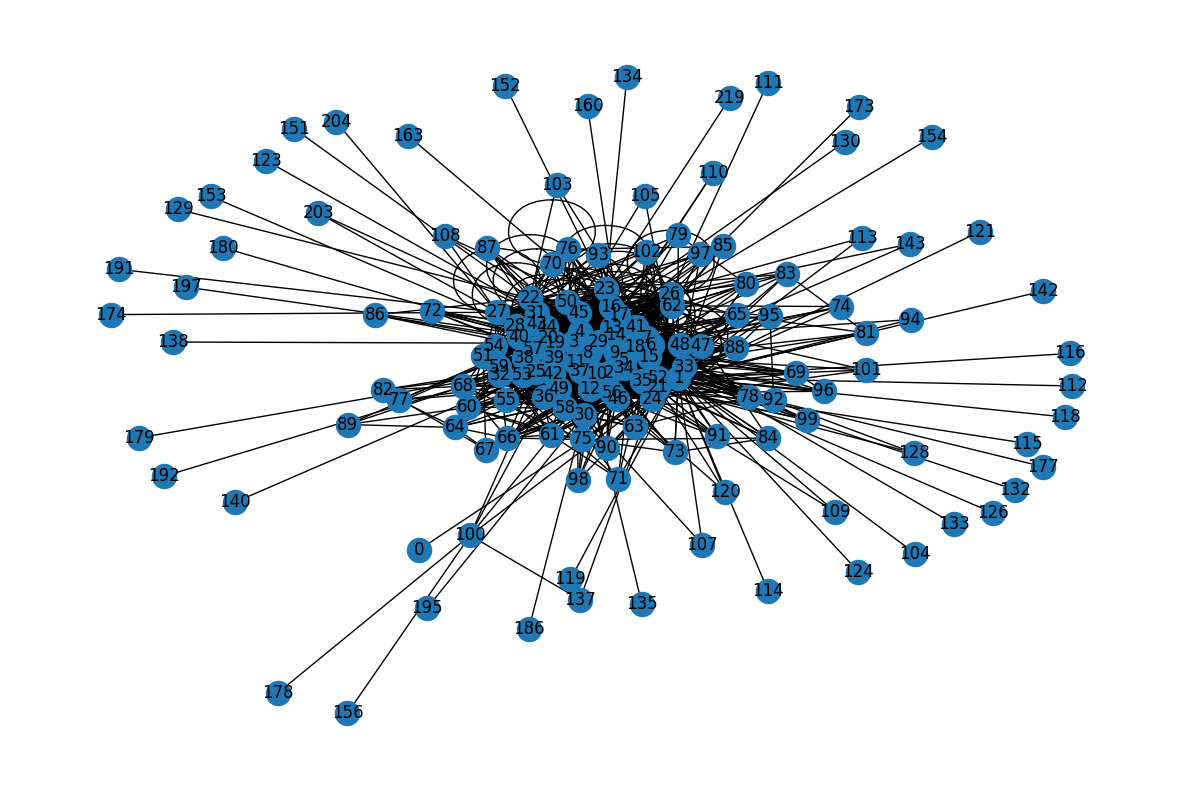

In [ ]:
# se crea el grafo dirigido a partir del Dataframe

G = nx.from_pandas_edgelist(
    dfRestante,
    source = "num_users",
    target = "num_unique_apis",
    create_using = nx.Graph
)
fig, ax = plt.subplots(figsize=(15,10))
nx.draw(G, with_labels=True, ax=ax)

In [ ]:
print("Número de nodos:", G.number_of_nodes())
print("Número de ejes:", G.number_of_edges())

Número de nodos: 156
Número de ejes: 1491


In [ ]:
#Matriz de adyacencia
adjM = nx.adjacency_matrix(G)
adjM = adjM.todense()
adjM

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## **ANÁLISIS DE ANOMALIAS**

### **Métricas de centralidad**

In [ ]:
degree      = pd.Series(dict(nx.degree(G)), name='degree')
eigenvector =  pd.Series(nx.eigenvector_centrality(G), name='eigenvector')
pagerank    =  pd.Series(nx.pagerank(G), name='pagerank')
centralidad = pd.concat([degree, eigenvector, pagerank], axis=1)
centralidad.index.name = 'node'
centralidad.head(10)

,degree,eigenvector,pagerank
node,,,
1,123,0.203874,0.051460
13,59,0.167134,0.016776
27,52,0.143193,0.017461
11,55,0.158756,0.015157
9,60,0.164912,0.017117
46,32,0.100505,0.009408
10,58,0.162484,0.016388
4,59,0.166004,0.016550
2,61,0.165530,0.017164


In [ ]:
# Top 3 nodos para cada métrica
# ======================================================================================
for col in centralidad.columns:
    top_nodos = centralidad[col].sort_values(ascending=False).head(3).index.to_list()
    top_nodos.sort()
    print(f"Nodos con mayor {col}: {top_nodos}")

Nodos con mayor degree: [1, 5, 15]
Nodos con mayor eigenvector: [1, 5, 13]
Nodos con mayor pagerank: [1, 15, 19]


In [ ]:
# Pagerank de cada nodo
# ======================================================================================
pagerank = nx.pagerank(G)
pagerank

{1: 0.051459891051012986,
 13: 0.01677648216606023,
 27: 0.01746058844583796,
 11: 0.015156837166376249,
 9: 0.01711741338416157,
 46: 0.009407740558115415,
 10: 0.016387533012250665,
 4: 0.016549749058259677,
 2: 0.01716404275991911,
 38: 0.009053603317696165,
 26: 0.014729592746783149,
 12: 0.017777894745864355,
 18: 0.01657196481376967,
 34: 0.010999385089041556,
 66: 0.004872277905558794,
 17: 0.01826063191531327,
 29: 0.01169014697344345,
 3: 0.016430567765917708,
 36: 0.009384438104397362,
 40: 0.007934580803155481,
 16: 0.018501679291479008,
 41: 0.010721772628299856,
 42: 0.00854107867622105,
 23: 0.015519067274756234,
 25: 0.014136395964283344,
 8: 0.015169717487519638,
 6: 0.015779516429070772,
 7: 0.015164563986607437,
 15: 0.018952896053061295,
 62: 0.005655825399348714,
 43: 0.009359316403122722,
 55: 0.006876059655749377,
 14: 0.013206181089434731,
 5: 0.018779228061344966,
 24: 0.013098177017239572,
 84: 0.003052010161369219,
 31: 0.01388048481195276,
 20: 0.016348945677

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.covariance import EllipticEnvelope

# Normalizar los valores de PageRank para que estén en el rango [0, 1]
pagerank_values = np.array(list(pagerank.values())).reshape(-1, 1)
scaler = MinMaxScaler()
pagerank_normalized = scaler.fit_transform(pagerank_values)

In [ ]:
# Detectar anomalías utilizando Elliptic Envelope
outlier_detector = EllipticEnvelope(contamination=0.05)  # Porcentaje de valores atípicos esperados
outlier_detector.fit(pagerank_normalized)
outliers = outlier_detector.predict(pagerank_normalized)

In [ ]:
outlier_users = [num_users for i, num_users in enumerate(pagerank) if outliers[i] == -1]
print("Usuarios anómalos:", outlier_users)

Usuarios anómalos: [1, 27, 12, 17, 16, 15, 5, 19]


Muestra los usuarios anómalos detectados utilizando el algoritmo PageRank y el resultado del algoritmo de Envoltura Elíptica. La variable outlier_users contiene una lista de usuarios anómalos identificados, y se imprime para mostrar los usuarios que han sido considerados como anómalos dentro del dataset de nuestro proyecto.
Comparación de comportamiento predicho y el actual ya clasificado.


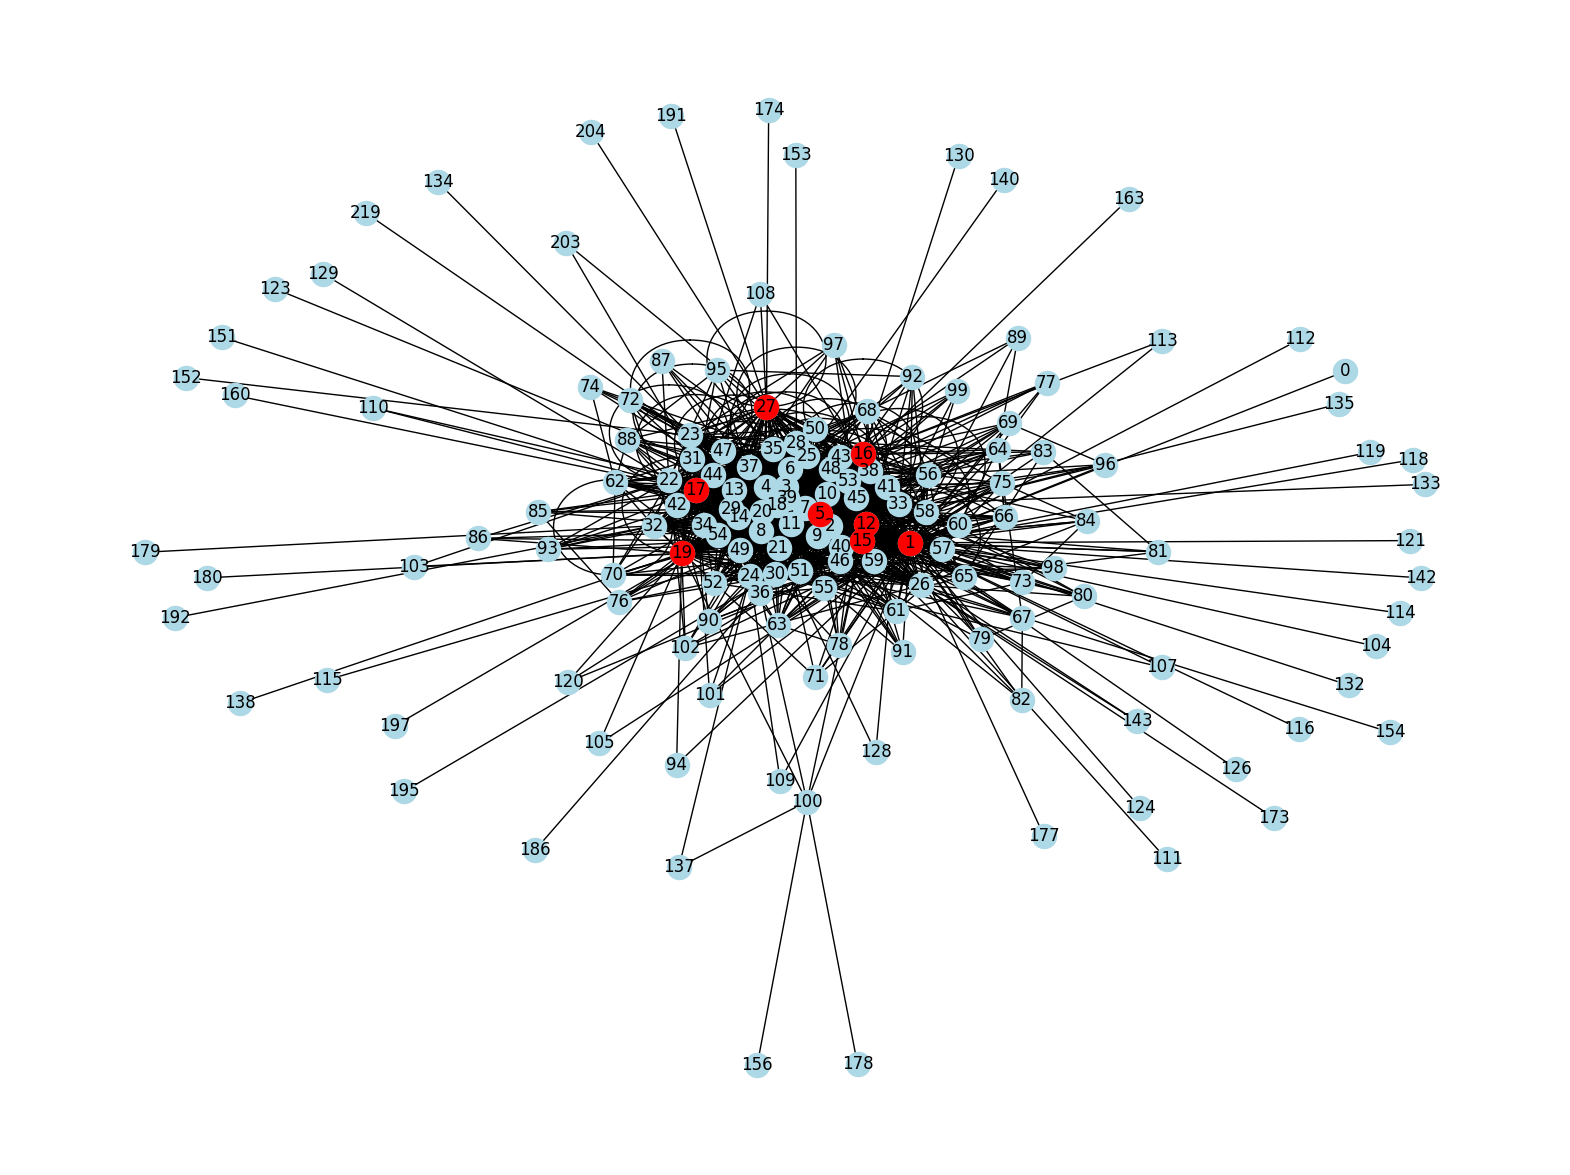

In [ ]:
pos = nx.spring_layout(G)  # Define la disposición de los nodos en el grafo
fig, ax = plt.subplots(figsize=(20,15))
nx.draw(G, pos, node_color='lightblue', with_labels=True)
nx.draw_networkx_nodes(G, pos, nodelist=outlier_users, node_color='red')
plt.show()

In [ ]:
nodo_id = 27
vecinos = list(G.neighbors(nodo_id))
print("Vecinos del nodo {nodo_id}:", vecinos)

grado = G.degree[nodo_id]
print("Grado del nodo {nodo_id}:", grado)

Vecinos del nodo {nodo_id}: [1, 9, 204, 13, 39, 108, 191, 97, 203, 174, 12, 7, 2, 10, 25, 3, 4, 26, 17, 20, 15, 38, 60, 27, 5, 34, 49, 58, 8, 29, 32, 45, 50, 6, 35, 11, 18, 88, 28, 33, 43, 22, 16, 23, 14, 56, 37, 19, 31, 41, 54]
Grado del nodo {nodo_id}: 52


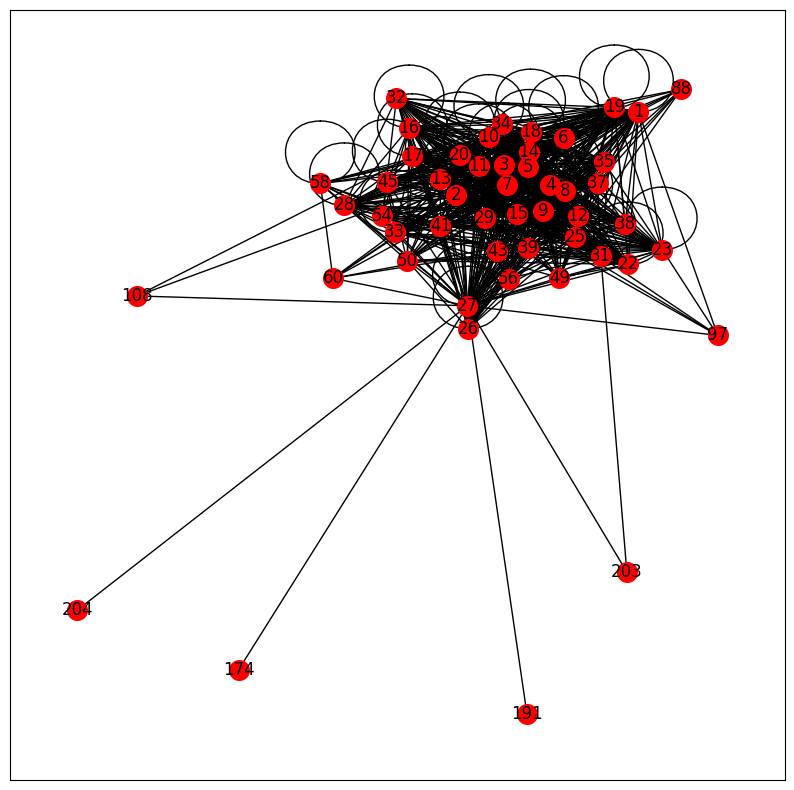

In [ ]:
nodos = vecinos + [nodo_id]
G_s = nx.subgraph(G, nodos)

spring_pos = nx.spring_layout(G)
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw_networkx(G_s, pos=spring_pos, with_labels=True, node_size=200, node_color='r', ax=ax)

In [ ]:
predictions = ['outlier' if node in outlier_users else 'normal' for node in dfRestante['num_users']]
actual_values = dfRestante['behavior_type'].astype(str)


In [ ]:
results = pd.DataFrame({'Prediction': predictions, 'Actual': actual_values})
print(results)

      Prediction   Actual
0        outlier  outlier
1        outlier  outlier
2        outlier  outlier
3        outlier  outlier
4        outlier  outlier
...          ...      ...
34418     normal   normal
34419    outlier  outlier
34420     normal   normal
34421    outlier  outlier
34422    outlier  outlier

[34423 rows x 2 columns]


Se muestra las predicciones junto con los valores reales de comportamiento en la columna 'behavior_type'. Esto permite una comparación visual entre las predicciones y los valores reales para cada nodo en el conjunto de datos.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
anomaly_data = dfRestante[dfRestante['num_users'].isin(outlier_users)]
anomaly_data = anomaly_data[['num_users', 'behavior_type']]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(anomaly_data['num_users'], anomaly_data['behavior_type'], test_size=0.2, random_state=42)


In [ ]:
lr = LogisticRegression()
lr.fit(X_train.to_numpy().reshape(-1, 1), y_train)


LogisticRegression()

In [ ]:
y_pred = lr.predict(X_test.to_numpy().reshape(-1, 1))


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy*100:.2f}%')


Precisión del modelo: 97.94%


En este proceso se detecta anomalías, prepara los datos, entrena un modelo de regresión logística y evalúa su efectividad en la predicción de anomalías basadas en el comportamiento real de los nodos. Los resultados de esta evaluación proporcionan información sobre la capacidad del modelo para identificar con precisión nodos anómalos en la red.